#### EDA of the Pull Request Data between January 2018 and December 2023

Importing necessary libraries

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import ast
from collections import defaultdict
import os
sns.set(style="whitegrid")
%matplotlib inline



Section 1: Defining File Paths


In [54]:
COVID_PHASES = {
    "pre": ("2018-01-01", "2020-01-29"),
    "during": ("2020-01-30", "2023-05-05"),
    "post": ("2023-05-06", "2023-12-31")
}

REPOS = {
    "scikit-learn": "../data/raw/scikit-learn/scikit-learn_prs_2018_2023.csv",
    "pytorch": "../data/raw/pytorch/pytorch_prs_2018_2023.csv",
    "kubernetes": "../data/raw/kubernetes/kubernetes_prs_2018_2023.csv",
    "apache-spark": "../data/raw/apache/apache_spark_prs_2018_2023.csv"
}

KNOWN_BOTS = {
    "dependabot", "appveyorbot", "bors", "codecov", "coveralls", "circleci", "travis-ci",
    "github-actions", "jenkins", "azure-pipelines", "humbug", "neco-bot", "pyup-bot",
    "automerge", "rebase-bot", "auto-merge", "ci-bot", "codecov-commenter"
}


Section 2: Defining Helper Functions

In [55]:
def assign_covid_phase(date):
    # Make date timezone-naive if needed
    if pd.notnull(date) and date.tzinfo is not None:
        date = date.tz_convert(None)  # remove timezone
    for phase, (start, end) in COVID_PHASES.items():
        start = pd.to_datetime(start)
        end = pd.to_datetime(end)
        if start <= date <= end:
            return phase
    return None


def load_and_process_repo(repo_name, file_path):
    df = pd.read_csv(file_path, parse_dates=["created_at", "closed_at", "merged_at"])
    df["covid_phase"] = df["created_at"].apply(assign_covid_phase)
    df["repo"] = repo_name
    return df

def detect_bots_per_repo(df, repo_name):
    user_counts = Counter()
    user_roles = {}
    list_fields = ["commit_authors", "comment_authors", "review_comment_authors"]

    for field in list_fields:
        df[field] = df[field].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else (x or []))

    for _, row in df.iterrows():
        if pd.notnull(row["author"]):
            user_counts[row["author"]] += 1
            user_roles.setdefault(row["author"], set()).add("author")
        for field in list_fields:
            for user in row[field]:
                user_counts[user] += 1
                user_roles.setdefault(user, set()).add(field)

    records = []
    for user, count in user_counts.items():
        roles = list(user_roles[user])
        u_lower = user.lower()
        is_known = u_lower in KNOWN_BOTS
        only_comments = set(roles).issubset({"comment_authors", "review_comment_authors"})
        high_volume = count > 500
        suspected = is_known or only_comments or high_volume
        records.append({
            "repository": repo_name,
            "username": user,
            "mention_count": count,
            "roles": roles,
            "is_known_bot": is_known,
            "only_comments": only_comments,
            "high_volume": high_volume,
            "suspected_bot": suspected
        })

    bots_df = pd.DataFrame(records)
    suspected_bots = set(bots_df[bots_df["suspected_bot"]]["username"])

    df["author"] = df["author"].apply(lambda x: None if x in suspected_bots else x)
    for col in list_fields:
        df[col] = df[col].apply(lambda lst: [u for u in lst if u not in suspected_bots])
    
    return df, bots_df

Section 3: Load and Clean Data per Repo

In [56]:
repo_data = {}

for repo, path in REPOS.items():
    df = load_and_process_repo(repo, path)
    df_cleaned, bots = detect_bots_per_repo(df, repo)
    repo_data[repo] = {
        "df": df_cleaned,
        "bots": bots
    }


Section 4: Bot Detection Summary

In [57]:
# Combine bots from all repos
all_bots = pd.concat([content["bots"] for content in repo_data.values()], ignore_index=True)

# Group and summarize
summary = all_bots.groupby("repository")[["suspected_bot", "mention_count"]].agg(
    total_suspected_bots=("suspected_bot", "sum"),
    total_mentions=("mention_count", "sum")
)

print("Bot Detection Summary:")
print(summary)

Bot Detection Summary:
              total_suspected_bots  total_mentions
repository                                        
apache-spark                   795          134476
kubernetes                    1706          283037
pytorch                       1121          320965
scikit-learn                   445           43249


Section 5: Per-Repository EDA

In [79]:
for repo, content in repo_data.items():
    df = content["df"]
    print(f"{repo.upper()}")

    # PRs per phase
    print("PRs by COVID phase:")
    print(df["covid_phase"].value_counts())
    
    # Contributors per phase
    def extract_contributors(row):
        contributors = set()
        for col in ["author", "merged_by", "assignees", "reviewers", "commit_authors", "comment_authors", "review_comment_authors"]:
            val = row[col]
            if isinstance(val, list):
                contributors.update(val)
            elif pd.notnull(val):
                contributors.add(val)
        return list(contributors)
    
    df['all_contributors'] = df.apply(extract_contributors, axis=1)
    df_exploded = df.explode("all_contributors")

    # Clean out malformed contributors
    df_exploded = df.explode("all_contributors")
    df_exploded = df_exploded[df_exploded["all_contributors"].notnull()]
    df_exploded = df_exploded[df_exploded["all_contributors"].astype(str).str.strip() != ""]
    df_exploded = df_exploded[df_exploded["all_contributors"] != "[]"]

    contributor_counts = df_exploded.groupby("covid_phase")["all_contributors"].nunique()

    print("Unique contributors per phase:")
    print(contributor_counts)
    print("-" * 50)


SCIKIT-LEARN
PRs by COVID phase:
covid_phase
during    6211
pre       3436
post      1085
Name: count, dtype: int64
Unique contributors per phase:
covid_phase
during    1633
post       300
pre       1143
Name: all_contributors, dtype: int64
--------------------------------------------------
PYTORCH
PRs by COVID phase:
covid_phase
during    46773
pre       18264
post      10265
Name: count, dtype: int64
Unique contributors per phase:
covid_phase
during    8650
post      2799
pre       3095
Name: all_contributors, dtype: int64
--------------------------------------------------
KUBERNETES
PRs by COVID phase:
covid_phase
during    20341
pre       19803
post       3213
Name: count, dtype: int64
Unique contributors per phase:
covid_phase
during    15566
post       3664
pre       14112
Name: all_contributors, dtype: int64
--------------------------------------------------
APACHE-SPARK
PRs by COVID phase:
covid_phase
during    13654
pre        7229
post       3475
Name: count, dtype: int64
Uni

Section 6: PR Activity Over Time

C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1039237885.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")


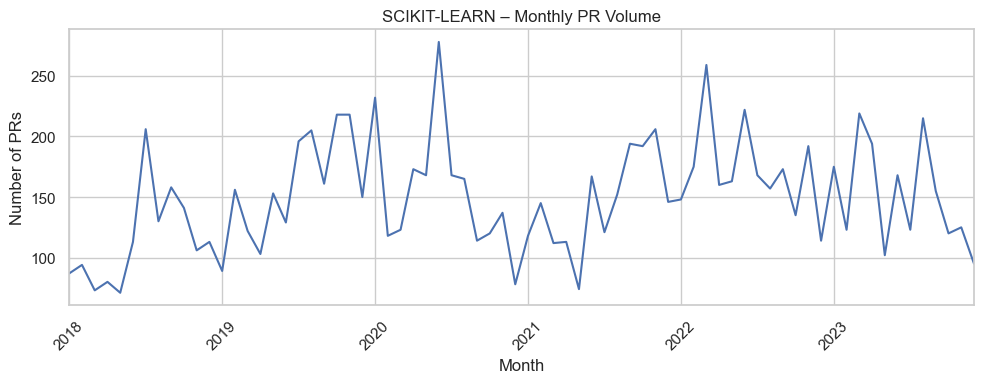

C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1039237885.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")


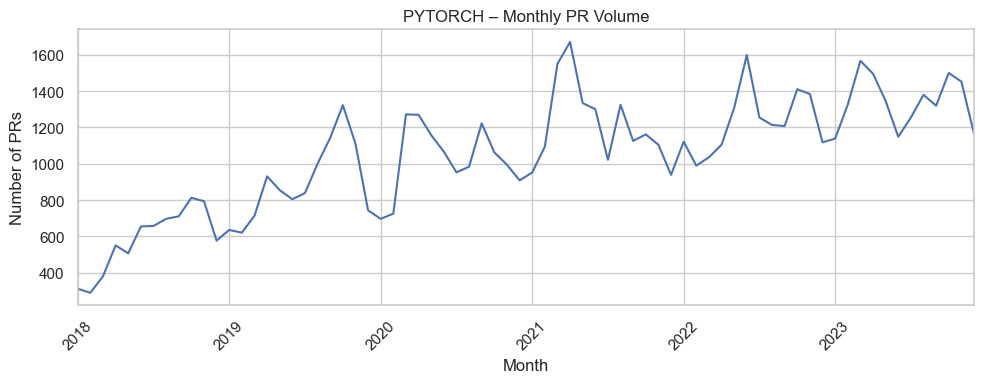

C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1039237885.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")


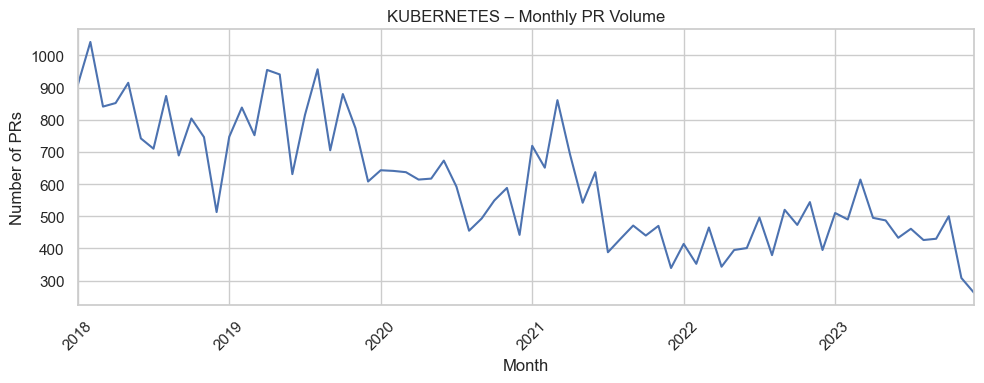

C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1039237885.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")


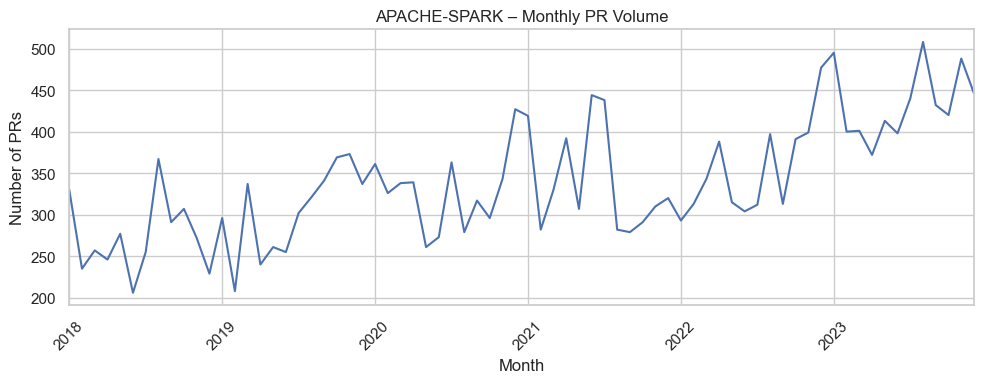

In [59]:
for repo, content in repo_data.items():
    df = content["df"]
    df["month"] = df["created_at"].dt.to_period("M")
    monthly = df.groupby("month")["pr_number"].count()

    monthly.plot(figsize=(10, 4), title=f"{repo.upper()} – Monthly PR Volume")
    plt.ylabel("Number of PRs")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Section 7: PR Duration and Merge Rates

In [60]:
df["pr_duration_days"] = (df["closed_at"] - df["created_at"]).dt.days
df["is_merged"] = df["merged_at"].notnull()

# Compute stats
duration_stats = df.groupby("covid_phase")["pr_duration_days"].describe()
merge_rate = df.groupby("covid_phase")["is_merged"].mean()

print("PR Duration (days):")
print(duration_stats)
print("\nMerge Rates per Phase:")
print(merge_rate)

PR Duration (days):
               count       mean         std  min  25%  50%   75%     max
covid_phase                                                             
during       13652.0  19.842294   55.389914  0.0  0.0  1.0   7.0  1185.0
post          3471.0  14.382022   39.398779  0.0  0.0  0.0   5.0   405.0
pre           7229.0  37.450823  100.980088  0.0  0.0  3.0  15.0   944.0

Merge Rates per Phase:
covid_phase
during    0.000146
post      0.000288
pre       0.000000
Name: is_merged, dtype: float64


Section 8: Contributor Role Breakdown

In [61]:
from collections import defaultdict

role_counts = defaultdict(lambda: defaultdict(int))

for _, row in df.iterrows():
    phase = row["covid_phase"]
    if pd.notnull(row["author"]):
        role_counts["author"][phase] += 1
    for col in ["reviewers", "comment_authors", "review_comment_authors"]:
        for user in row[col]:
            role_counts[col][phase] += 1

# Convert to DataFrame for display
import pandas as pd
role_df = pd.DataFrame(role_counts).fillna(0).astype(int)
print("Role Counts by COVID Phase:")
print(role_df)


Role Counts by COVID Phase:
        reviewers  author  review_comment_authors  comment_authors
pre         16187    3308                    3282             4876
None           67      20                      15               16
during      38295    4734                    3911             5050
post         9886    1314                     967             1182


Section 9: Save Cleaned Data

In [62]:
for repo, content in repo_data.items():
    content["df"].to_csv(f"../data/processed/{repo}_cleaned_prs.csv", index=False)
    content["bots"].to_csv(f"../data/processed/{repo}_detected_bots.csv", index=False)
#

Section 10: Save a Summary Table Per Repo

In [63]:
summary_rows = []

for repo, content in repo_data.items():
    df = content["df"]
    bots = content["bots"]

    pr_counts = df["covid_phase"].value_counts().to_dict()
    contributor_counts = df.explode("all_contributors").groupby("covid_phase")["all_contributors"].nunique().to_dict()
    bot_count = bots["suspected_bot"].sum()

    summary_rows.append({
        "repository": repo,
        "total_prs": len(df),
        "total_contributors": df["all_contributors"].explode().nunique(),
        "bots_detected": bot_count,
        "prs_pre": pr_counts.get("pre", 0),
        "prs_during": pr_counts.get("during", 0),
        "prs_post": pr_counts.get("post", 0),
        "contributors_pre": contributor_counts.get("pre", 0),
        "contributors_during": contributor_counts.get("during", 0),
        "contributors_post": contributor_counts.get("post", 0),
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("../data/processed/repo_summary_overview.csv", index=False)
display(summary_df)


,repository,total_prs,total_contributors,bots_detected,prs_pre,prs_during,prs_post,contributors_pre,contributors_during,contributors_post
0,scikit-learn,10766,2810,445,3436,6211,1085,1144,1634,301
1,pytorch,75414,13121,1121,18264,46773,10265,3096,8651,2800
2,kubernetes,43416,28789,1706,19803,20341,3213,14113,15567,3665
3,apache-spark,24387,2115,795,7229,13654,3475,956,1239,445


Section 11: Contributor Overlap and Survival Rates

In [64]:
# Get sets of contributors per phase
df_exploded = df.explode("all_contributors")  # Make sure this is already done above

pre_contributors = set(df_exploded[df_exploded["covid_phase"] == "pre"]["all_contributors"].dropna())
during_contributors = set(df_exploded[df_exploded["covid_phase"] == "during"]["all_contributors"].dropna())
post_contributors = set(df_exploded[df_exploded["covid_phase"] == "post"]["all_contributors"].dropna())

# Compute overlaps
pre_during_overlap = pre_contributors & during_contributors
during_post_overlap = during_contributors & post_contributors
pre_post_overlap = pre_contributors & post_contributors

# Print sizes and survival rates
print("Contributor Overlaps:")
print(f"Pre ∩ During: {len(pre_during_overlap)} ({len(pre_during_overlap) / len(pre_contributors):.2%} of Pre)")
print(f"During ∩ Post: {len(during_post_overlap)} ({len(during_post_overlap) / len(during_contributors):.2%} of During)")
print(f"Pre ∩ Post: {len(pre_post_overlap)} ({len(pre_post_overlap) / len(pre_contributors):.2%} of Pre)")


Contributor Overlaps:
Pre ∩ During: 276 (28.87% of Pre)
During ∩ Post: 244 (19.69% of During)
Pre ∩ Post: 86 (9.00% of Pre)


Section 12: Save Monthly PR Volume Plots

In [81]:
os.makedirs("../figures", exist_ok=True)

for repo, content in repo_data.items():
    df = content["df"]
    df["month"] = df["created_at"].dt.to_period("M")
    monthly = df.groupby("month")["pr_number"].count()

    fig, ax = plt.subplots(figsize=(10, 4))
    monthly.plot(ax=ax, title=f"{repo.upper()} – Monthly PR Volume")
    plt.ylabel("Number of PRs")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"../figures/{repo}_monthly_prs.png")
    plt.close()


C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\2071602441.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\2071602441.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\2071602441.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\2071602441.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")


Section 13: Top Contributers Per Phase

In [66]:
top_contributors_by_repo = {}

for repo, content in repo_data.items():
    df = content["df"]
    df_long = df.explode("all_contributors")

    top_per_phase = {}
    for phase in ["pre", "during", "post"]:
        filtered = df_long[df_long["covid_phase"] == phase]
        top = filtered["all_contributors"].value_counts().head(10)
        top_per_phase[phase] = top

    top_contributors_by_repo[repo] = top_per_phase
    # Save per repo
    for phase, data in top_per_phase.items():
        data.to_csv(f"../data/processed/{repo}_top_contributors_{phase}.csv", header=["count"])


Section 14: Contributor Overlap Across Phases

In [67]:
overlap_stats = defaultdict(dict)

for repo, content in repo_data.items():
    df = content["df"]
    df_long = df.explode("all_contributors")

    contributors_by_phase = {
        phase: set(df_long[df_long["covid_phase"] == phase]["all_contributors"].dropna())
        for phase in ["pre", "during", "post"]
    }

    # Jaccard overlap between phases
    overlap_stats[repo]["pre_during"] = len(contributors_by_phase["pre"] & contributors_by_phase["during"]) / max(len(contributors_by_phase["pre"] | contributors_by_phase["during"]), 1)
    overlap_stats[repo]["during_post"] = len(contributors_by_phase["during"] & contributors_by_phase["post"]) / max(len(contributors_by_phase["during"] | contributors_by_phase["post"]), 1)
    overlap_stats[repo]["pre_post"] = len(contributors_by_phase["pre"] & contributors_by_phase["post"]) / max(len(contributors_by_phase["pre"] | contributors_by_phase["post"]), 1)

overlap_df = pd.DataFrame.from_dict(overlap_stats, orient="index")
overlap_df.to_csv("../data/processed/contributor_overlap.csv")
display(overlap_df)


,pre_during,during_post,pre_post
scikit-learn,0.074246,0.042003,0.026278
pytorch,0.058002,0.072794,0.021306
kubernetes,0.113153,0.085634,0.037828
apache-spark,0.143825,0.169444,0.065399


Section 15: Contributor Role Breakdown

In [68]:
role_counts = defaultdict(lambda: defaultdict(int))

for _, row in df.iterrows():
    phase = row["covid_phase"]
    if pd.notnull(row["author"]):
        role_counts["author"][phase] += 1
    for col in ["reviewers", "comment_authors", "review_comment_authors"]:
        for user in row[col]:
            role_counts[col][phase] += 1

# Convert to DataFrame for display
import pandas as pd
role_df = pd.DataFrame(role_counts).fillna(0).astype(int)
print("Role Counts by COVID Phase:")
print(role_df)


Role Counts by COVID Phase:
        reviewers  author  review_comment_authors  comment_authors
pre         16187    3308                    3282             4876
None           67      20                      15               16
during      38295    4734                    3911             5050
post         9886    1314                     967             1182


Section 16: PR Duration Analysis

In [69]:
duration_stats = []

for repo, content in repo_data.items():
    df = content["df"].copy()

    df["closed_duration_days"] = (df["closed_at"] - df["created_at"]).dt.total_seconds() / 86400
    df["merged_duration_days"] = (df["merged_at"] - df["created_at"]).dt.total_seconds() / 86400

    durations = df.groupby("covid_phase")[["closed_duration_days", "merged_duration_days"]].median().reset_index()
    durations["repository"] = repo
    duration_stats.append(durations)

duration_df = pd.concat(duration_stats)
duration_df.to_csv("../data/processed/pr_durations_by_phase.csv", index=False)
display(duration_df)


,covid_phase,closed_duration_days,merged_duration_days,repository
0,during,2.150249,1.958113,scikit-learn
1,post,3.694317,3.749491,scikit-learn
2,pre,2.820758,1.824502,scikit-learn
0,during,3.343270,0.889664,pytorch
1,post,2.502390,0.642928,pytorch
2,pre,1.843449,0.643484,pytorch
0,during,8.187726,6.036956,kubernetes
1,post,9.897789,6.177095,kubernetes
2,pre,5.674248,4.140145,kubernetes
0,during,1.426262,0.675544,apache-spark


Section 17: Contributor Acyivity Over Time

In [70]:
# Add month and quarter columns
for repo, content in repo_data.items():
    df = content["df"]
    df["month"] = df["created_at"].dt.to_period("M")
    df["quarter"] = df["created_at"].dt.to_period("Q")
    df_exploded = df.explode("all_contributors")
    
    monthly_prs = df.groupby("month").size()
    monthly_contributors = df_exploded.groupby("month")["all_contributors"].nunique()

    print(f"{repo.upper()} - Monthly PRs and Contributors")
    print("Monthly PRs:")
    print(monthly_prs.tail())
    print("Monthly Unique Contributors:")
    print(monthly_contributors.tail())


SCIKIT-LEARN - Monthly PRs and Contributors
Monthly PRs:
month
2023-08    215
2023-09    155
2023-10    120
2023-11    125
2023-12     95
Freq: M, dtype: int64
Monthly Unique Contributors:
month
2023-08    92
2023-09    56
2023-10    53
2023-11    54
2023-12    43
Freq: M, Name: all_contributors, dtype: int64


C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1891723229.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1891723229.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["created_at"].dt.to_period("Q")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1891723229.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1891723229.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["created_at"].dt.to_period("Q")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1891723229.py:4: UserWarning: Converting to PeriodArray/Index representation will drop time

PYTORCH - Monthly PRs and Contributors
Monthly PRs:
month
2023-08    1380
2023-09    1320
2023-10    1500
2023-11    1453
2023-12    1166
Freq: M, dtype: int64
Monthly Unique Contributors:
month
2023-08    651
2023-09    593
2023-10    666
2023-11    691
2023-12    532
Freq: M, Name: all_contributors, dtype: int64
KUBERNETES - Monthly PRs and Contributors
Monthly PRs:
month
2023-08    426
2023-09    430
2023-10    500
2023-11    308
2023-12    262
Freq: M, dtype: int64
Monthly Unique Contributors:
month
2023-08    764
2023-09    785
2023-10    817
2023-11    539
2023-12    467
Freq: M, Name: all_contributors, dtype: int64


C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1891723229.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["created_at"].dt.to_period("Q")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1891723229.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")


APACHE-SPARK - Monthly PRs and Contributors
Monthly PRs:
month
2023-08    508
2023-09    432
2023-10    420
2023-11    488
2023-12    446
Freq: M, dtype: int64
Monthly Unique Contributors:
month
2023-08    143
2023-09     95
2023-10    118
2023-11    120
2023-12     93
Freq: M, Name: all_contributors, dtype: int64


C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\1891723229.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["created_at"].dt.to_period("Q")


Section 18: New vs Returning Contributors per COVID Phase

In [71]:
for repo, content in repo_data.items():
    df = content["df"]
    df_exploded = df.explode("all_contributors")
    
    contributor_phases = df_exploded.groupby("all_contributors")["covid_phase"].unique()

    new_counts = {"pre": 0, "during": 0, "post": 0}
    returning_counts = {"pre": 0, "during": 0, "post": 0}

    for contributor, phases in contributor_phases.items():
        if "pre" in phases:
            new_counts["pre"] += 1
        if "during" in phases and "pre" not in phases:
            new_counts["during"] += 1
        elif "during" in phases:
            returning_counts["during"] += 1
        if "post" in phases and "during" not in phases and "pre" not in phases:
            new_counts["post"] += 1
        elif "post" in phases:
            returning_counts["post"] += 1

    print(f"{repo.upper()} - New vs Returning Contributors")
    print("New contributors:", new_counts)
    print("Returning contributors:", returning_counts)


SCIKIT-LEARN - New vs Returning Contributors
New contributors: {'pre': 1144, 'during': 1442, 'post': 217}
Returning contributors: {'pre': 0, 'during': 192, 'post': 84}
PYTORCH - New vs Returning Contributors
New contributors: {'pre': 3096, 'during': 8007, 'post': 2008}
Returning contributors: {'pre': 0, 'during': 644, 'post': 792}
KUBERNETES - New vs Returning Contributors
New contributors: {'pre': 14113, 'during': 12550, 'post': 2097}
Returning contributors: {'pre': 0, 'during': 3017, 'post': 1568}
APACHE-SPARK - New vs Returning Contributors
New contributors: {'pre': 956, 'during': 963, 'post': 195}
Returning contributors: {'pre': 0, 'during': 276, 'post': 250}


Section 19: Contributor Engagement Distribution

In [72]:
for repo, content in repo_data.items():
    df_exploded = content["df"].explode("all_contributors")
    contributor_counts = df_exploded["all_contributors"].value_counts()

    one_time = (contributor_counts == 1).sum()
    frequent = (contributor_counts >= 5).sum()

    print(f"{repo.upper()}")
    print(f"Total contributors: {len(contributor_counts)}")
    print(f"One-time contributors: {one_time}")
    print(f"Contributors with 5+ PRs: {frequent}")


SCIKIT-LEARN
Total contributors: 2810
One-time contributors: 1682
Contributors with 5+ PRs: 291
PYTORCH
Total contributors: 13121
One-time contributors: 8657
Contributors with 5+ PRs: 1857
KUBERNETES
Total contributors: 28789
One-time contributors: 19913
Contributors with 5+ PRs: 3726
APACHE-SPARK
Total contributors: 2115
One-time contributors: 991
Contributors with 5+ PRs: 522


Section 20: Top Contributors per Phase

In [73]:
for repo, content in repo_data.items():
    df_exploded = content["df"].explode("all_contributors")

    print(f"{repo.upper()} - Top Contributors per COVID Phase")
    for phase in ["pre", "during", "post"]:
        top = (df_exploded[df_exploded["covid_phase"] == phase]["all_contributors"]
               .value_counts()
               .head(10))
        print(f"Top in {phase}:")
        print(top)
        print("-" * 40)


SCIKIT-LEARN - Top Contributors per COVID Phase
Top in pre:
all_contributors
[]                    3428
agramfort              202
TomDLT                 150
jorisvandenbossche     113
GaelVaroquaux          105
['glemaitre']           66
albertcthomas           63
eamanu                  52
reshamas                52
jakirkham               33
Name: count, dtype: int64
----------------------------------------
Top in during:
all_contributors
[]               6200
Micky774          212
alfaro96          194
['glemaitre']     172
betatim           171
reshamas          156
lucyleeow         143
TomDLT            137
ArturoAmorQ       113
jmloyola           81
Name: count, dtype: int64
----------------------------------------
Top in post:
all_contributors
[]                  1085
betatim              114
OmarManzoor           78
Charlie-XIAO          64
ArturoAmorQ           63
Micky774              44
lucyleeow             43
Tialo                 42
StefanieSenger        38
scikit-learn

Section 21: Final Dataset Summary

In [74]:
# Recompute missing derived columns
for repo, content in repo_data.items():
    df = content["df"]

    # Duration and merge flag
    df["pr_duration_days"] = (df["closed_at"] - df["created_at"]).dt.days
    df["is_merged"] = df["merged_at"].notnull()

    # Store it back
    content["df"] = df


for repo, content in repo_data.items():
    df = content["df"]
    df_exploded = df.explode("all_contributors")

    total_prs = len(df)
    total_contributors = df_exploded["all_contributors"].nunique()
    median_duration = df["pr_duration_days"].median()
    merge_rate = df["is_merged"].mean()

    print(f"{repo.upper()} - Dataset Summary")
    print(f"Total PRs: {total_prs}")
    print(f"Total contributors: {total_contributors}")
    print(f"Median PR duration: {median_duration:.2f} days")
    print(f"Merge rate: {merge_rate:.2%}")
    print("-" * 50)


SCIKIT-LEARN - Dataset Summary
Total PRs: 10766
Total contributors: 2810
Median PR duration: 2.00 days
Merge rate: 75.61%
--------------------------------------------------
PYTORCH - Dataset Summary
Total PRs: 75414
Total contributors: 13121
Median PR duration: 2.00 days
Merge rate: 5.16%
--------------------------------------------------
KUBERNETES - Dataset Summary
Total PRs: 43416
Total contributors: 28789
Median PR duration: 6.00 days
Merge rate: 68.47%
--------------------------------------------------
APACHE-SPARK - Dataset Summary
Total PRs: 24387
Total contributors: 2115
Median PR duration: 1.00 days
Merge rate: 0.01%
--------------------------------------------------


### Now to add some visualizations

Section 22: PR Volume and Contributors Over Time

C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\3502130804.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\3502130804.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["created_at"].dt.to_period("Q")


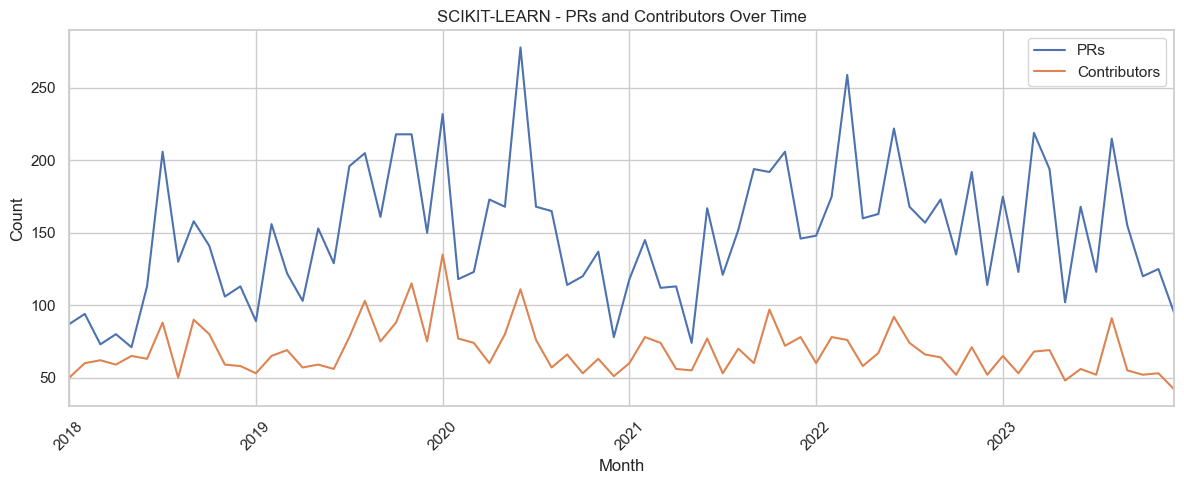

C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\3502130804.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\3502130804.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["created_at"].dt.to_period("Q")


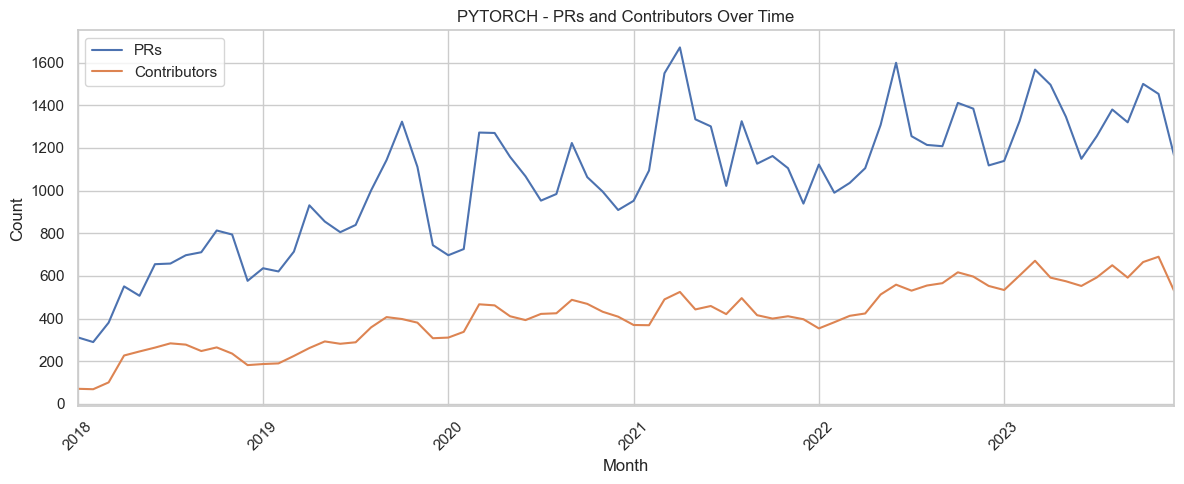

C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\3502130804.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\3502130804.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["created_at"].dt.to_period("Q")


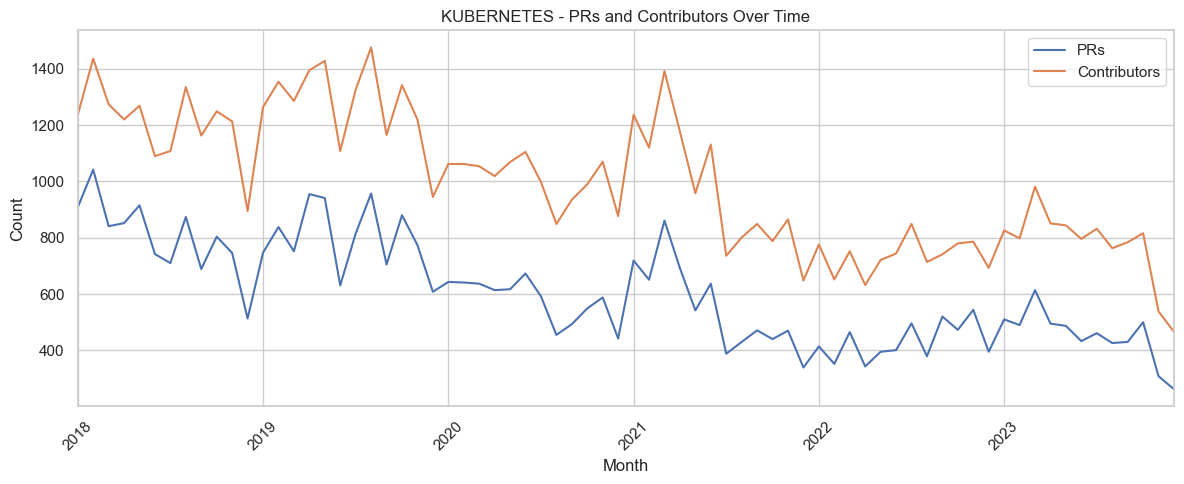

C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\3502130804.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M")
C:\Users\20225118\AppData\Local\Temp\ipykernel_15868\3502130804.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["created_at"].dt.to_period("Q")


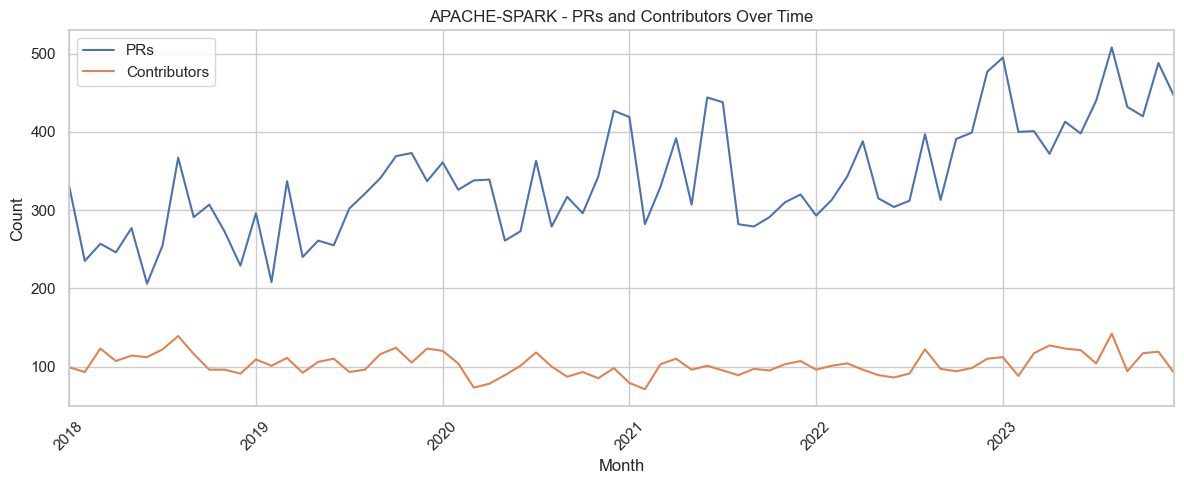

In [75]:
for repo, content in repo_data.items():
    df = content["df"].copy()
    df["month"] = df["created_at"].dt.to_period("M")
    df["quarter"] = df["created_at"].dt.to_period("Q")
    df_exploded = df.explode("all_contributors")
    
    # Clean contributors
    df_exploded = df_exploded[df_exploded["all_contributors"].notnull()]
    df_exploded = df_exploded[df_exploded["all_contributors"].astype(str).str.strip() != ""]
    df_exploded = df_exploded[df_exploded["all_contributors"] != "[]"]
    
    prs_per_month = df.groupby("month").size()
    contributors_per_month = df_exploded.groupby("month")["all_contributors"].nunique()

    plt.figure(figsize=(12, 5))
    prs_per_month.plot(label="PRs", legend=True)
    contributors_per_month.plot(label="Contributors", legend=True)
    plt.title(f"{repo.upper()} - PRs and Contributors Over Time")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Section 23: Top Contributors per Phase (Bar Plot)

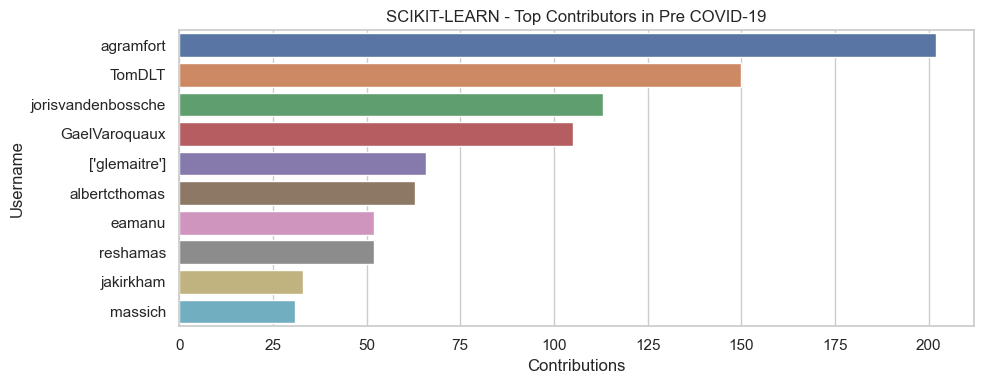

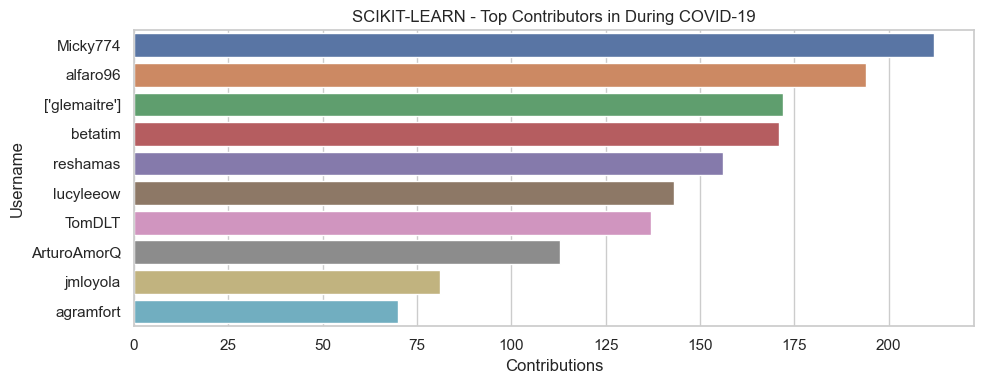

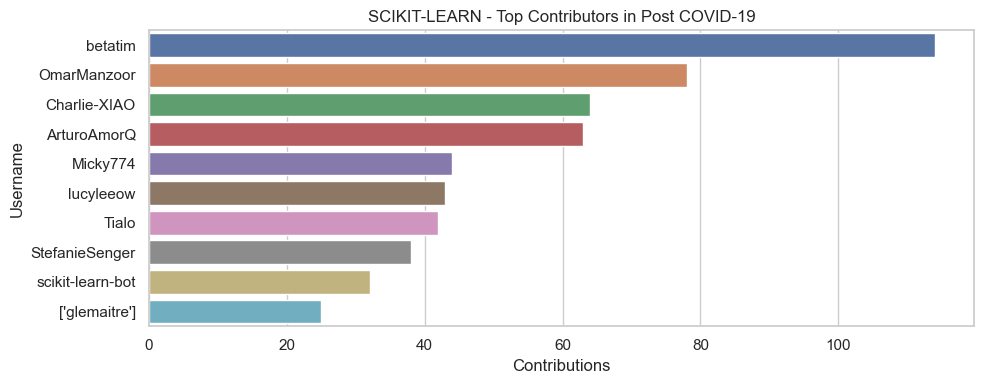

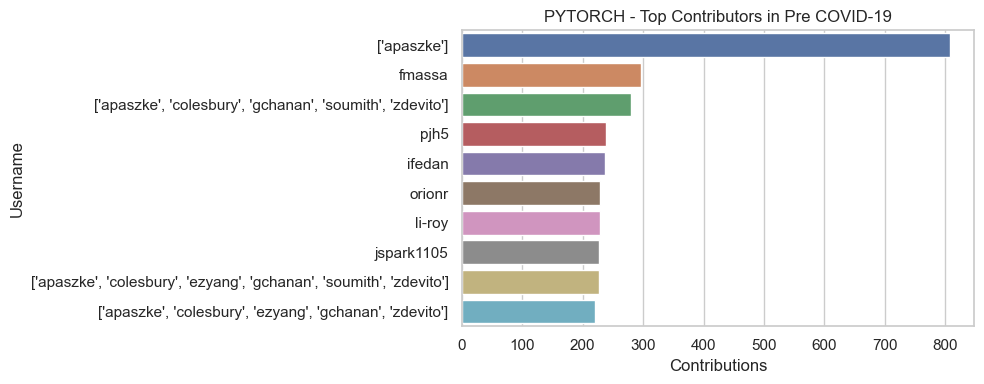

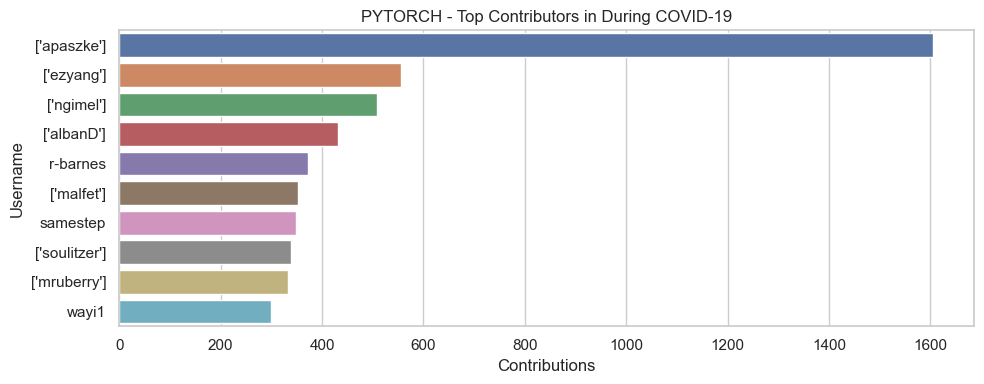

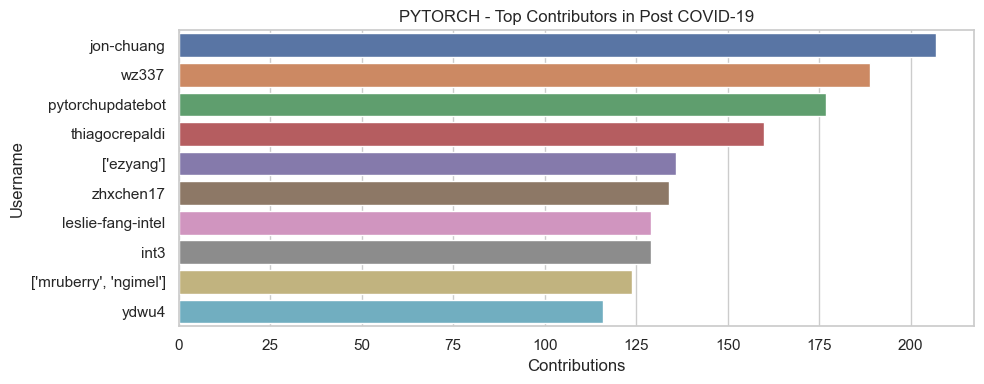

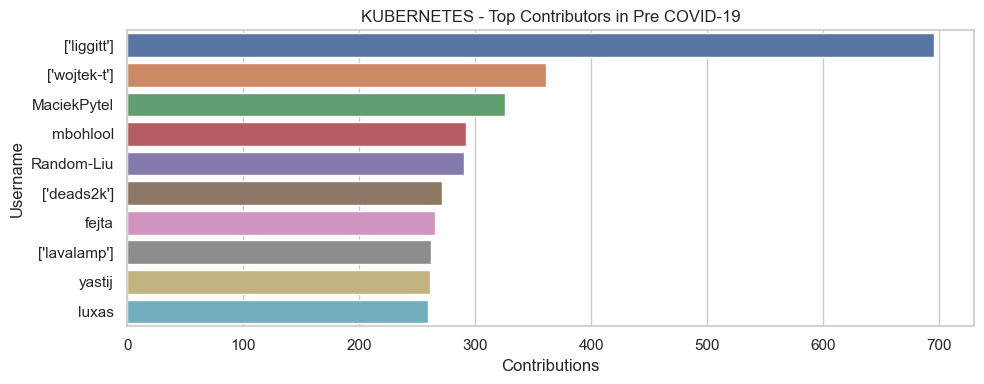

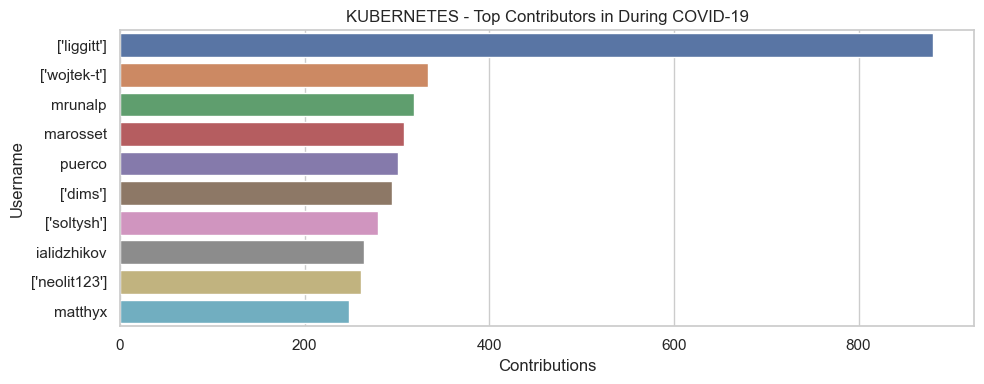

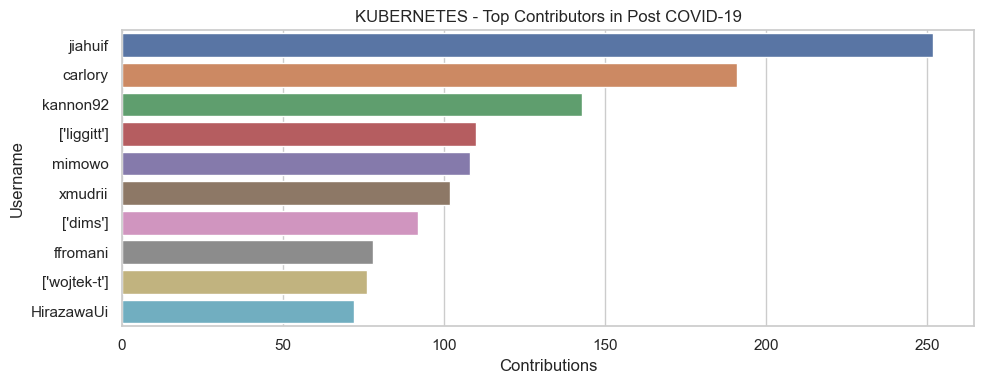

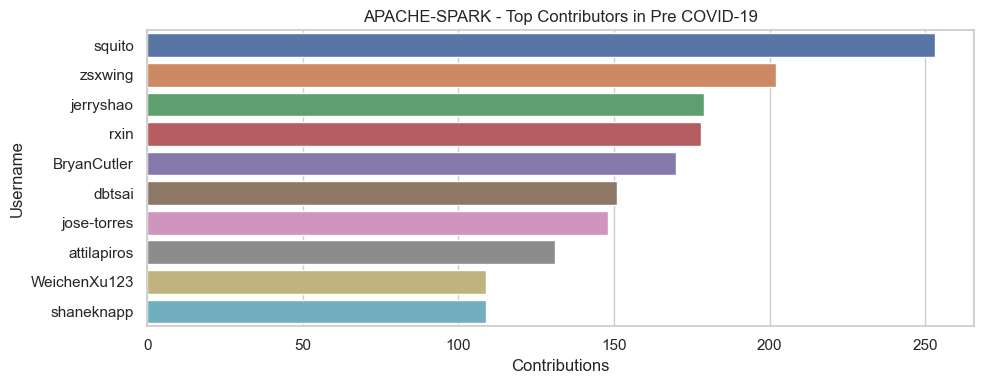

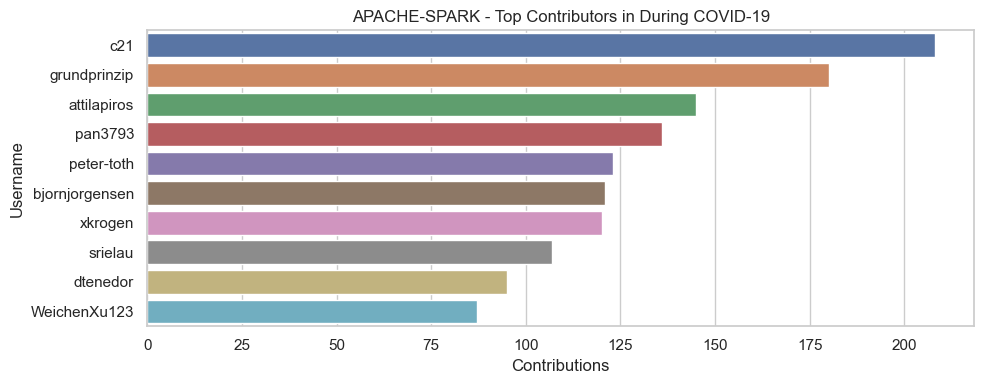

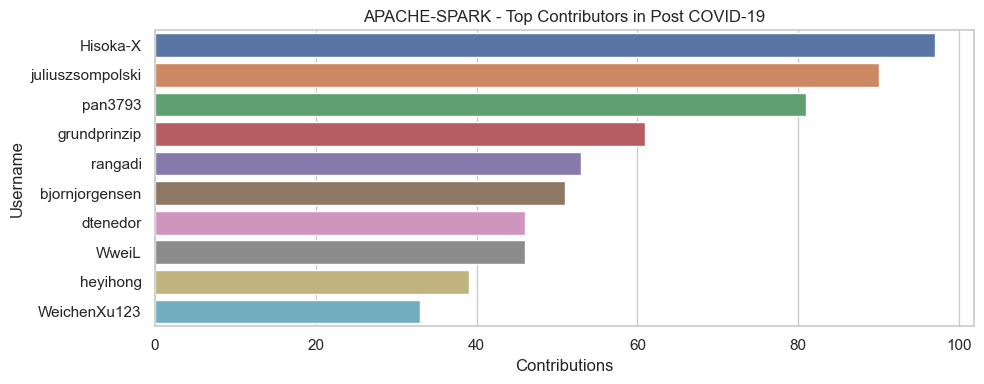

In [82]:
for repo, content in repo_data.items():
    df_exploded = content["df"].explode("all_contributors")

    df_exploded = df_exploded[df_exploded["all_contributors"].notnull()]
    df_exploded = df_exploded[df_exploded["all_contributors"].astype(str).str.strip() != ""]
    df_exploded = df_exploded[df_exploded["all_contributors"] != "[]"]

    for phase in ["pre", "during", "post"]:
        top = (df_exploded[df_exploded["covid_phase"] == phase]["all_contributors"]
               .value_counts()
               .head(10))

        plt.figure(figsize=(10, 4))
        sns.barplot(x=top.values, y=top.index, orient="h")
        plt.title(f"{repo.upper()} - Top Contributors in {phase.capitalize()} COVID-19")
        plt.xlabel("Contributions")
        plt.ylabel("Username")
        plt.tight_layout()
        plt.show()


Section 24: Histogram of PRs per Contributor

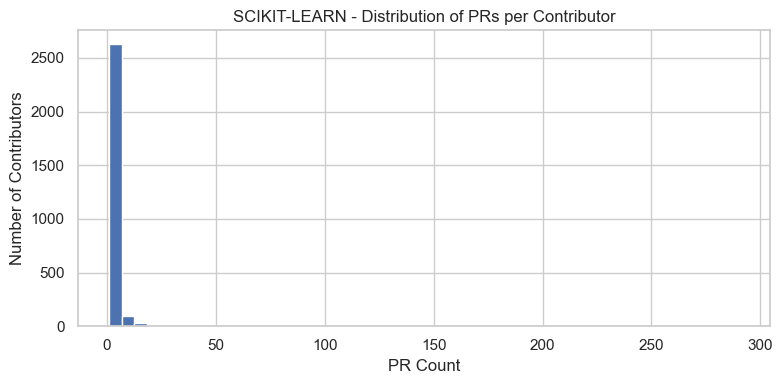

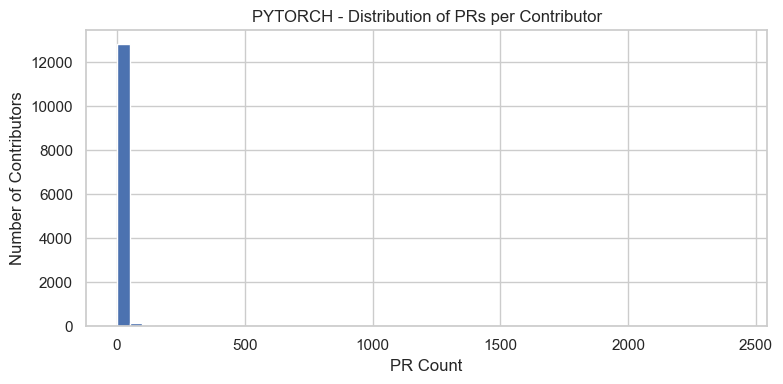

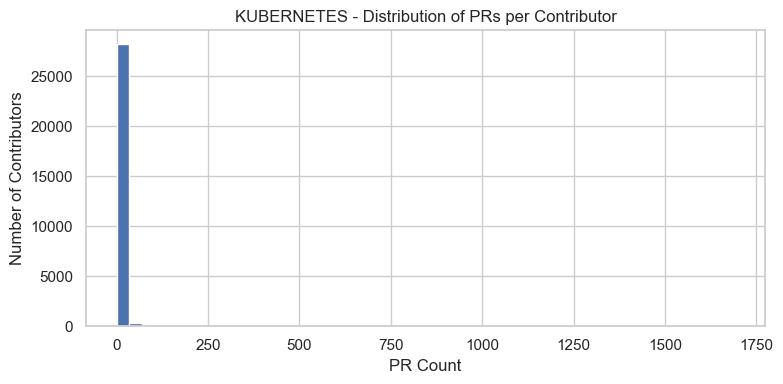

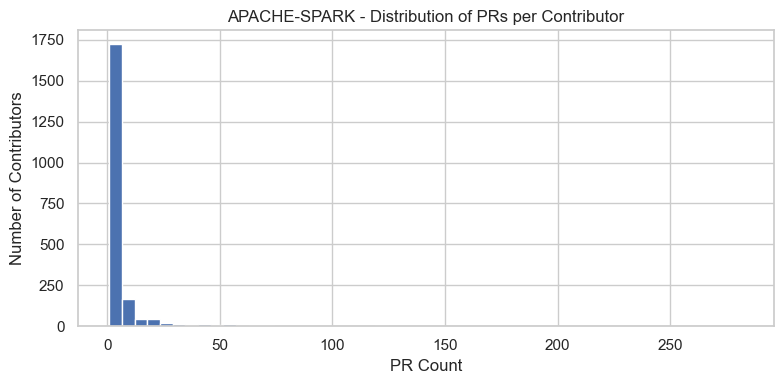

In [77]:
for repo, content in repo_data.items():
    df_exploded = content["df"].explode("all_contributors")

    df_exploded = df_exploded[df_exploded["all_contributors"].notnull()]
    df_exploded = df_exploded[df_exploded["all_contributors"].astype(str).str.strip() != ""]
    df_exploded = df_exploded[df_exploded["all_contributors"] != "[]"]

    contrib_counts = df_exploded["all_contributors"].value_counts()

    plt.figure(figsize=(8, 4))
    contrib_counts.hist(bins=50)
    plt.title(f"{repo.upper()} - Distribution of PRs per Contributor")
    plt.xlabel("PR Count")
    plt.ylabel("Number of Contributors")
    plt.tight_layout()
    plt.show()


Section 25: Pie Chart of One-time vs Frequent Contributors

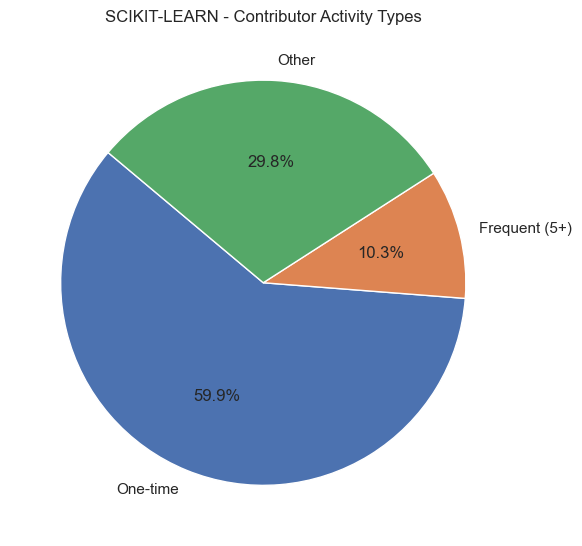

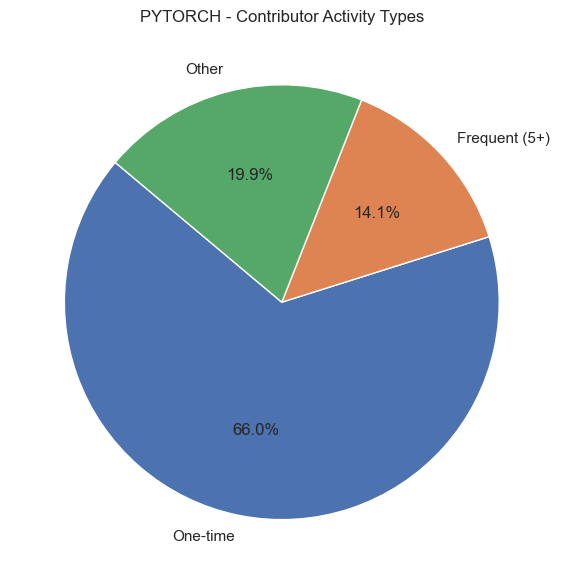

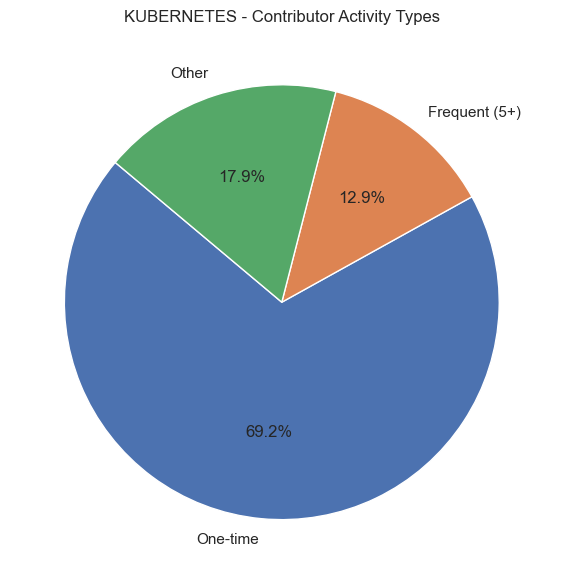

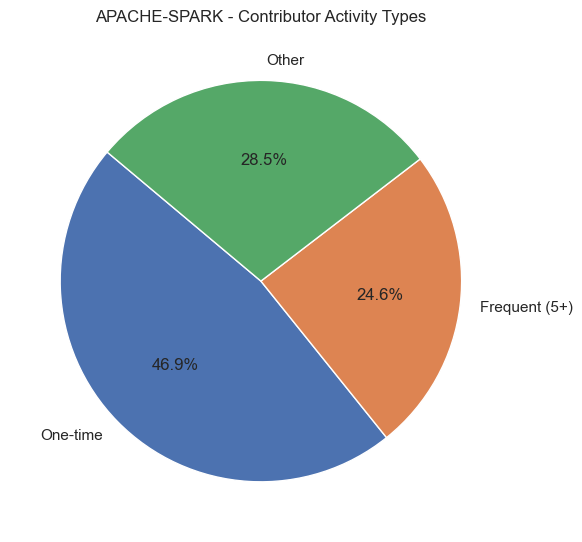

In [78]:
for repo, content in repo_data.items():
    df_exploded = content["df"].explode("all_contributors")

    df_exploded = df_exploded[df_exploded["all_contributors"].notnull()]
    df_exploded = df_exploded[df_exploded["all_contributors"].astype(str).str.strip() != ""]
    df_exploded = df_exploded[df_exploded["all_contributors"] != "[]"]

    counts = df_exploded["all_contributors"].value_counts()
    one_time = (counts == 1).sum()
    frequent = (counts >= 5).sum()
    other = len(counts) - one_time - frequent

    plt.figure(figsize=(6, 6))
    plt.pie([one_time, frequent, other], labels=["One-time", "Frequent (5+)", "Other"], autopct="%1.1f%%", startangle=140)
    plt.title(f"{repo.upper()} - Contributor Activity Types")
    plt.tight_layout()
    plt.show()
